### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [38]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [39]:
sat_var = 2
var_name = 'i0'

In [64]:
Paras = {
     'M0':['M0'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['i0'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}


In [65]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,i0
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.94774485180000012097
2017-11-02 01:00:00,0.94774666090000003749
2017-11-02 02:00:00,0.94774867349999991628
2017-11-02 03:00:00,0.94775088790000006078
2017-11-02 04:00:00,0.94775329120000006977


In [66]:
test = df.iloc[265:408,:]




In [67]:

df.head(7)

,i0
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.94774485180000012097
2017-11-02 01:00:00,0.94774666090000003749
2017-11-02 02:00:00,0.94774867349999991628
2017-11-02 03:00:00,0.94775088790000006078
2017-11-02 04:00:00,0.94775329120000006977
2017-11-02 05:00:00,0.94775561890000004084
2017-11-02 06:00:00,0.94775737910000001918


# Enter number of entries per day

In [68]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [69]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [70]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.head()

,i0
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.94774485180000012097
2017-11-02 01:00:00,0.94774666090000003749
2017-11-02 02:00:00,0.94774867349999991628
2017-11-02 03:00:00,0.94775088790000006078
2017-11-02 04:00:00,0.94775329120000006977


In [71]:
train.tail(6)

,i0
Epoch_Time_of_Clock,
2017-11-06 18:00:00,0.94797598880000000232
2017-11-06 19:00:00,0.94797786719999999061
2017-11-06 20:00:00,0.94797995060000006529
2017-11-06 21:00:00,0.94798223370000000987
2017-11-06 22:00:00,0.94798471139999995749
2017-11-06 23:00:00,0.94798737860000004130


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [72]:
from sklearn.preprocessing import StandardScaler




y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [73]:
import pickle
file_x = open(var_name+'X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [74]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [75]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00 -1.08393494661645628518 -1.05048167339747466897   
2017-11-03 00:00:00 -1.05048167339747466897 -1.01419576517137866034   
2017-11-03 01:00:00 -1.01419576517137866034 -0.97509051445012673298   
2017-11-03 02:00:00 -0.97509051445012673298 -0.93332676067460507152   
2017-11-03 03:00:00 -0.93332676067460507152 -0.89253734826897712651   
2017-11-03 04:00:00 -0.89253734826897712651 -0.85948949676728803038   
2017-11-03 05:00:00 -0.85948949676728803038 -0.83346673959095984863   
2017-11-03 06:00:00 -0.83346673959095984863 -0.80652414035896702327   
2017-11-03 07:00:00 -0.80652414035896702327 -0.77967990573789691666   
2017-11-03 08:00:00 -0.77967990573789691666 -0.76283828887052562706   
2017-11-03 09:00:00 -0.76283828887052562706 -0.75668518354626868039   
2017-11-03 10:00:00 -0.75668518354626868039 -0.75248607796687783100   
2017-11-03 11:00:00 -0.75248607796687783100 -0.74556865301390962131   
2017-11-03 12:00:00 -0.74556865301390962131 -0.73573883795994099444   
2017-11-03 13:00:00 -0.73573883795994099444 -0.72299530355480923216   
2017-11-03 14:00:00 -0.72299530355480923216 -0.70733937905015298320   
2017-11-03 15:00:00 -0.70733937905015298320 -0.68877372295072492037   
2017-11-03 16:00:00 -0.68877372295072492037 -0.66729567675177237085   
2017-11-03 17:00:00 -0.66729567675177237085 -0.64290789895804800747   
2017-11-03 18:00:00 -0.64290789895804800747 -0.61561038956660052435   
2017-11-03 19:00:00 -0.61561038956660052435 -0.58540314858038133838   
2017-11-03 20:00:00 -0.58540314858038133838 -0.55228883449971599706   
2017-11-03 21:00:00 -0.55228883449971599706 -0.51626611807591749059   
2017-11-03 22:00:00 -0.51626611807591749059 -0.47733632855914870374   
2017-11-03 23:00:00 -0.47733632855914870374 -0.43549946594793376153   
2017-11-04 00:00:00 -0.43549946594793376153 -0.39075685949686278509   
2017-11-04 01:00:00 -0.39075685949686278509 -0.34310850920445995493   
2017-11-04 02:00:00 -0.34310850920445995493 -0.29271126675079300883   
2017-11-04 03:00:00 -0.29271126675079300883 -0.24326709764080300946   
2017-11-04 04:00:00 -0.24326709764080300946 -0.20171070710318669827   
...                                     ...                     ...   
2017-11-04 18:00:00  0.08686979974925233827  0.11919719692482670659   
2017-11-04 19:00:00  0.11919719692482670659  0.15440641141371463929   
2017-11-04 20:00:00  0.15440641141371463929  0.19249478471411479719   
2017-11-04 21:00:00  0.19249478471411479719  0.23345832906815999763   
2017-11-04 22:00:00  0.23345832906815999763  0.27729438597700040159   
2017-11-04 23:00:00  0.27729438597700040159  0.32400029693735893366   
2017-11-05 00:00:00  0.32400029693735893366  0.37357207419431986972   
2017-11-05 01:00:00  0.37357207419431986972  0.42600838849181738022   
2017-11-05 02:00:00  0.42600838849181738022  0.48114840040077133665   
2017-11-05 03:00:00  0.48114840040077133665  0.53522501108447551044   
2017-11-05 04:00:00  0.53522501108447551044  0.58118122418267104123   
2017-11-05 05:00:00  0.58118122418267104123  0.61904761247861750384   
2017-11-05 06:00:00  0.61904761247861750384  0.65573096691217447329   
2017-11-05 07:00:00  0.65573096691217447329  0.69008946042174812430   
2017-11-05 08:00:00  0.69008946042174812430  0.71303234180537578002   
2017-11-05 09:00:00  0.71303234180537578002  0.72457157432485275184   
2017-11-05 10:00:00  0.72457157432485275184  0.73398533364989626548   
2017-11-05 11:00:00  0.73398533364989626548  0.74620913070715011450   
2017-11-05 12:00:00  0.74620913070715011450  0.76142241445011016321   
2017-11-05 13:00:00  0.76142241445011016321  0.77959461209846847574   
2017-11-05 14:00:00  0.77959461209846847574  0.80069780936486378842   
2017-11-05 15:00:00  0.8

In [76]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [78]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][['i0']]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.81793013888119592281 1.86053530887603790767   
2017-11-07 01:00:00 1.86053530887603790767 1.90538957245589291034   
2017-11-07 02:00:00 1.90538957245589291034 1.95226828611450597961   
2017-11-07 03:00:00 1.95226828611450597961 1.99740302176648376609   
2017-11-07 04:00:00 1.99740302176648376609 2.03379527011628535860   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.90538957245589291034 1.95226828611450597961   
2017-11-07 01:00:00 1.95226828611450597961 1.99740302176648376609   
2017-11-07 02:00:00 1.99740302176648376609 2.03379527011628535860   
2017-11-07 03:00:00 2.03379527011628535860 2.06169625969998504544   
2017-11-07 04:00:00 2.06169625969998504544 2.08835439910641529337   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 1.99740302176648376609 2.03379527011628535860   
2017-11-07 01:00:00 2.03379527011628535860 2.06169625969998504544   
2017-11-07 02:00:00 2.06169625969998504544 2.08835439910641529337   
2017-11-07 03:00:00 2.08835439910641529337 2.11221712254718330115   
2017-11-07 04:00:00 2.11221712254718330115 2.12307710753691347705   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 2.06169625969998504544 2.08835439910641529337   
2017-11-07 01:00:00 2.08835439910641529337 2.11221712254718330115   
2017-11-07 02:00:00 2.11221712254718330115 2.12307710753691347705   
2017-11-07 03:00:00 2.12307710753691347705 2.12101145066031149256   
2017-11-07 04:00:00 2.12101145066031149256 2.11655181178190066049   

tensor                                                             \
feature                                                             
time step                              t+9                   t+10   
Epoch_Time_of_Clock                                                 
2017-11-07 00:00:00 2.11221712254718330115 2.12307710753691347705   
2017-11-07 01:00:00 2.12307710753691347705 2.12101145066031149256   
2017-11-07 02:00:00 2.12101145066031149256 2.11655181178190066049   
2017-11-07 03:00:00 2.11655181178190066049 2.11525313303876316695   
2017-11-07 04:00:00 2.11525313303876316695 2.11724302257787000414   

tensor                       ...                                X  \
feature                      ...                               i0   
time step                    ...                              t-9   
Epoch_Time_of_Clock          ...                                    
2017-11-07 00:00:00          ...           1.53044360603726614656   
2017-11-07 01:00:00          ...           1.54683593588769996430   
2017-11-07 02:00:00          ...           1.56615660685584501266   
2017-11-07 03:00:00          ...           1.58833516860928547487   
2017-11-07 04:00:00          ...           1.61330382932183402644   

tensor                                                             \
feature                                                             
time step                              t-8                    t-7   
Epoch_Time_of_Clock                                          

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [79]:
#Image('./images/simple_encoder_decoder.png')

In [80]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [82]:
LATENT_DIM = 64
BATCH_SIZE = 32
EPOCHS = 500

In [83]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [84]:
model.compile(optimizer='RMSprop', loss='mse')

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_2 (Flatten)          (None, 24)                0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [86]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [87]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [88]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/500
73/73 [==============================] - 5s 65ms/step - loss: 0.5015 - val_loss: 1.1448
Epoch 2/500
73/73 [==============================] - 0s 1ms/step - loss: 0.2377 - val_loss: 0.7952
Epoch 3/500
73/73 [==============================] - 0s 2ms/step - loss: 0.1444 - val_loss: 0.5693
Epoch 4/500
73/73 [==============================] - 0s 1ms/step - loss: 0.1309 - val_loss: 0.6756
Epoch 5/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0918 - val_loss: 0.4610
Epoch 6/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0949 - val_loss: 0.5021
Epoch 7/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.4304
Epoch 8/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.3760
Epoch 9/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0597 - val_loss: 0.4055
Epoch 10/500
73/73 [==============================] - 0s 2ms/ste

73/73 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.1040
Epoch 83/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0146 - val_loss: 0.0841
Epoch 84/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0264 - val_loss: 0.0653
Epoch 85/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.1431
Epoch 86/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0145 - val_loss: 0.1108
Epoch 87/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0119 - val_loss: 0.1549
Epoch 88/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0674
Epoch 89/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0125 - val_loss: 0.0559
Epoch 90/500
73/73 [==============================] - 0s 981us/step - loss: 0.0244 - val_loss: 0.0739
Epoch 91/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0226 - val_loss: 0.1633
Epoch 92/50

73/73 [==============================] - 0s 4ms/step - loss: 0.0176 - val_loss: 0.1272
Epoch 164/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0663
Epoch 165/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0806
Epoch 166/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0394
Epoch 167/500
73/73 [==============================] - 0s 981us/step - loss: 0.0146 - val_loss: 0.0240
Epoch 168/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0351
Epoch 169/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0167 - val_loss: 0.1461
Epoch 170/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0107 - val_loss: 0.0628
Epoch 171/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0572
Epoch 172/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0086 - val_loss: 0.0445
Ep

73/73 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0428
Epoch 245/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0137 - val_loss: 0.0841
Epoch 246/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0081 - val_loss: 0.0528
Epoch 247/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0066 - val_loss: 0.0804
Epoch 248/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0065 - val_loss: 0.0324
Epoch 249/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0112 - val_loss: 0.0260
Epoch 250/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0117 - val_loss: 0.0315
Epoch 251/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.1263
Epoch 252/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0468
Epoch 253/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0388
Epoc

73/73 [==============================] - 0s 2ms/step - loss: 0.0081 - val_loss: 0.1222
Epoch 326/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0807
Epoch 327/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.1719
Epoch 328/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0349
Epoch 329/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0128 - val_loss: 0.1446
Epoch 330/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0111 - val_loss: 0.0435
Epoch 331/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0089 - val_loss: 0.1362
Epoch 332/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0561
Epoch 333/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0869
Epoch 334/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0374
Epoc

73/73 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.4660
Epoch 407/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.4079
Epoch 408/500
73/73 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.3356
Epoch 409/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.6838
Epoch 410/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.5117
Epoch 411/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.3903
Epoch 412/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0102 - val_loss: 0.2891
Epoch 413/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0083 - val_loss: 0.6709
Epoch 414/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.5077
Epoch 415/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.4486
Epoc

73/73 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.3948
Epoch 488/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.3486
Epoch 489/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.6604
Epoch 490/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.4764
Epoch 491/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.3845
Epoch 492/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.3424
Epoch 493/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.6505
Epoch 494/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.4726
Epoch 495/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.3920
Epoch 496/500
73/73 [==============================] - 0s 1ms/step - loss: 0.0068 - val_loss: 0.3480
Epoc

In [93]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [94]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-10 23:00:00 2.62265369727382235965 2.62293948635102358580   
2017-11-11 00:00:00 2.62293948635102358580 2.62686476611500863143   
2017-11-11 01:00:00 2.62686476611500863143 2.63491870112744441812   
2017-11-11 02:00:00 2.63491870112744441812 2.64739106822044734102   
2017-11-11 03:00:00 2.64739106822044734102 2.65997376318911982196   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                                 
2017-11-10 23:00:00 2.62686476611500863143 2.63491870112744441812   
2017-11-11 00:00:00 2.63491870112744441812 2.64739106822044734102   
2017-11-11 01:00:00 2.64739106822044734102 2.65997376318911982196   
2017-11-11 02:00:00 2.65997376318911982196 2.66415691774884821896   
2017-11-11 03:00:00 2.66415691774884821896 2.66035791688019562784   

tensor                                                             \
feature                                                             
time step                              t+5                    t+6   
Epoch_Time_of_Clock                                                 
2017-11-10 23:00:00 2.64739106822044734102 2.65997376318911982196   
2017-11-11 00:00:00 2.65997376318911982196 2.66415691774884821896   
2017-11-11 01:00:00 2.66415691774884821896 2.66035791688019562784   
2017-11-11 02:00:00 2.66035791688019562784 2.65766485328479928896   
2017-11-11 03:00:00 2.65766485328479928896 2.65519111619057923690   

tensor                                                             \
feature                                                             
time step                              t+7                    t+8   
Epoch_Time_of_Clock                                                 
2017-11-10 23:00:00 2.66415691774884821896 2.66035791688019562784   
2017-11-11 00:00:00 2.66035791688019562784 2.65766485328479928896   
2017-11-11 01:00:00 2.65766485328479928896 2.65519111619057923690   
2017-11-11 02:00:00 2.65519111619057923690 2.64213254917219808604   
2017-11-11 03:00:00 2.64213254917219808604 2.61777534416320900590   

tensor                                                             \
feature                                                             
time step                              t+9                   t+10   
Epoch_Time_of_Clock                                                 
2017-11-10 23:00:00 2.65766485328479928896 2.65519111619057923690   
2017-11-11 00:00:00 2.65519111619057923690 2.64213254917219808604   
2017-11-11 01:00:00 2.64213254917219808604 2.61777534416320900590   
2017-11-11 02:00:00 2.61777534416320900590 2.59172467270689832475   
2017-11-11 03:00:00 2.59172467270689832475 2.56905960489359230792   

tensor                       ...                                X  \
feature                      ...                               i0   
time step                    ...                              t-9   
Epoch_Time_of_Clock          ...                                    
2017-11-10 23:00:00          ...           2.71237817545319526147   
2017-11-11 00:00:00          ...           2.70316646235950308608   
2017-11-11 01:00:00          ...           2.69270392357723364896   
2017-11-11 02:00:00          ...           2.68147972367100617674   
2017-11-11 03:00:00          ...           2.66998169794789719234   

tensor                                                             \
feature                                                             
time step                              t-8                    t-7   
Epoch_Time_of_Clock                                          

In [95]:
test_inputs.dataframe.head(50)

tensor                              target                         \
feature                                  y                          
time step                              t+1                    t+2   
Epoch_Time_of_Clock                                                 
2017-11-10 23:00:00 2.62265369727382235965 2.62293948635102358580   
2017-11-11 00:00:00 2.62293948635102358580 2.62686476611500863143   
2017-11-11 01:00:00 2.62686476611500863143 2.63491870112744441812   
2017-11-11 02:00:00 2.63491870112744441812 2.64739106822044734102   
2017-11-11 03:00:00 2.64739106822044734102 2.65997376318911982196   
2017-11-11 04:00:00 2.65997376318911982196 2.66415691774884821896   
2017-11-11 05:00:00 2.66415691774884821896 2.66035791688019562784   
2017-11-11 06:00:00 2.66035791688019562784 2.65766485328479928896   
2017-11-11 07:00:00 2.65766485328479928896 2.65519111619057923690   
2017-11-11 08:00:00 2.65519111619057923690 2.64213254917219808604   
2017-11-11 09:00:00 2.64213254917219808604 2.61777534416320900590   
2017-11-11 10:00:00 2.61777534416320900590 2.59172467270689832475   
2017-11-11 11:00:00 2.59172467270689832475 2.56905960489359230792   
2017-11-11 12:00:00 2.56905960489359230792 2.54986920057569532716   
2017-11-11 13:00:00 2.54986920057569532716 2.53402718085639877543   
2017-11-11 14:00:00 2.53402718085639877543 2.52140593759463538248   
2017-11-11 15:00:00 2.52140593759463538248 2.51187786263605516979   
2017-11-11 16:00:00 2.51187786263605516979 2.50531667709122851662   
2017-11-11 17:00:00 2.50531667709122851662 2.50159477281170916640   
2017-11-11 18:00:00 2.50159477281170916640 2.50058587090068851211   
2017-11-11 19:00:00 2.50058587090068851211 2.50216236321414742250   
2017-11-11 20:00:00 2.50216236321414742250 2.50619664160363964100   
2017-11-11 21:00:00 2.50619664160363964100 2.51256242717530753339   
2017-11-11 22:00:00 2.51256242717530753339 2.52113344102939240798   
2017-11-11 23:00:00 2.52113344102939240798 2.53178207502482566227   
2017-11-12 00:00:00 2.53178207502482566227 2.54437939176299821042   
2017-11-12 01:00:00 2.54437939176299821042 2.55880177084742754801   
2017-11-12 02:00:00 2.55880177084742754801 2.57477937422205016560   
2017-11-12 03:00:00 2.57477937422205016560 2.58885348940521753391   
2017-11-12 04:00:00 2.58885348940521753391 2.59468225735770641194   
2017-11-12 05:00:00 2.59468225735770641194 2.59319349564501333560   
2017-11-12 06:00:00 2.59319349564501333560 2.59231353113407791966   
2017-11-12 07:00:00 2.59231353113407791966 2.59115575305134537842   
2017-11-12 08:00:00 2.59115575305134537842 2.58011498985500509207   
2017-11-12 09:00:00 2.58011498985500509207 2.55877119806121644530   
2017-11-12 10:00:00 2.55877119806121644530 2.53608619147628333579   
2017-11-12 11:00:00 2.53608619147628333579 2.51679343478959660629   
2017-11-12 12:00:00 2.51679343478959660629 2.50097800010307125262   
2017-11-12 13:00:00 2.50097800010307125262 2.48852955953661059141   
2017-11-12 14:00:00 2.48852955953661059141 2.47933379746258131249   
2017-11-12 15:00:00 2.47933379746258131249 2.47327639824596978713   
2017-11-12 16:00:00 2.47327639824596978713 2.47024304625914270517   
2017-11-12 17:00:00 2.47024304625914270517 2.47012075511872586375   
2017-11-12 18:00:00 2.47012075511872586375 2.47279520919413409175   
2017-11-12 19:00:00 2.47279520919413409175 2.47815342210642031162   
2017-11-12 20:00:00 2.47815342210642031162 2.48608240747368647305   
2017-11-12 21:00:00 2.48608240747368647305 2.49646784966682222517   
2017-11-12 22:00:00 2.49646784966682222517 2.50919410380065288635   
2017-11-12 23:00:00 2.50919410380065288635 2.52415084199950801036   
2017-11-13 00:00:00 2.52415084199950801036 2.54122109012952579477   

tensor                                                             \
feature                                                             
time step                              t+3                    t+4   
Epoch_Time_of_Clock                                               

In [96]:
test_inputs.dataframe.shape

(437, 48)

In [97]:
predictions = model.predict(test_inputs['X'])

In [98]:
predictions

array([[2.0026844, 2.1842792, 2.2893772, ..., 2.7244248, 2.7259634,
        2.7272081],
       [2.001444 , 2.1829839, 2.2880135, ..., 2.723197 , 2.7247374,
        2.725984 ],
       [2.0004845, 2.181991 , 2.2869549, ..., 2.72223  , 2.7237725,
        2.7250206],
       ...,
       [2.3421104, 2.5271783, 2.624424 , ..., 3.0250018, 3.0262852,
        3.027317 ],
       [2.3422937, 2.5273442, 2.624567 , ..., 3.0251122, 3.026396 ,
        3.0274284],
       [2.3424745, 2.5275059, 2.6247044, ..., 3.0252204, 3.0265043,
        3.0275369]], dtype=float32)

In [99]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-10 23:00:00  t+1 0.94800716041630184172 0.94805380090000002102
1 2017-11-11 00:00:00  t+1 0.94800706711165472207 0.94805382239999991256
2 2017-11-11 01:00:00  t+1 0.94800699491803597230 0.94805411769999992089
3 2017-11-11 02:00:00  t+1 0.94800695061536799368 0.94805472359999998222
4 2017-11-11 03:00:00  t+1 0.94800694119880901667 0.94805566190000001292
                timestamp     h             prediction                 actual
10483 2017-11-28 23:00:00  t+24 0.94808422766932043402 0.94844590279999996252
10484 2017-11-29 00:00:00  t+24 0.94808423557922993918 0.94844693110000000136
10485 2017-11-29 01:00:00  t+24 0.94808424384786560424 0.94844748090000008389
10486 2017-11-29 02:00:00  t+24 0.94808425222411896183 0.94844747709999988050
10487 2017-11-29 03:00:00  t+24 0.94808426038513671230 0.94844684439999993320
(10488, 4)


In [100]:


eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.00024524549898846123
t+10   0.00020640583913265017
t+11   0.00020612975171258673
t+12   0.00020612817085245388
t+13   0.00020632325675498724
t+14   0.00020665724437931370
t+15   0.00020710419262682741
t+16   0.00020764118086593594
t+17   0.00020825009573646993
t+18   0.00020891727348574773
t+19   0.00020963153487311777
t+2    0.00023154479718537663
t+20   0.00021038368241039216
t+21   0.00021116614718514170
t+22   0.00021197238283330832
t+23   0.00021279751373733867
t+24   0.00021363666834735076
t+3    0.00022427279603781192
t+4    0.00022035420751937191
t+5    0.00021648286273977957
t+6    0.00021306262569321363
t+7    0.00021026117384352697
t+8    0.00020833092338814029
t+9    0.00020709519357467248
Name: APE, dtype: float64

In [101]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.00020191316550726126

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

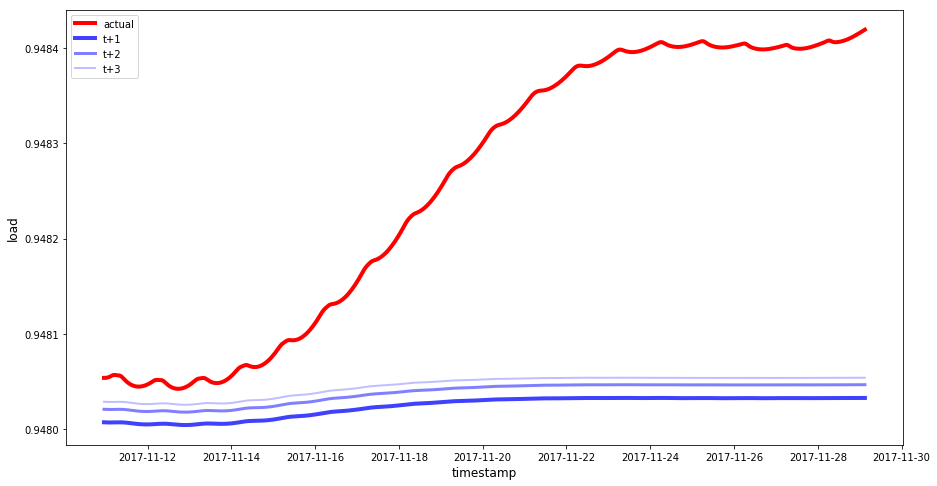

In [102]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [106]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [107]:
new_df = pd.DataFrame()

In [108]:
columns = [var_name] 

In [109]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [110]:
new_df = new_df.dropna( how = 'any')

In [111]:
new_df

,i0
Epoch_Time_of_Clock,
2017-11-21 00:00:00,0.94833814869999999431
2017-11-21 01:00:00,0.94834037090000000703
2017-11-21 02:00:00,0.94834267220000001419
2017-11-21 03:00:00,0.94834504519999995864
2017-11-21 04:00:00,0.94834747699999999426
2017-11-21 05:00:00,0.94834982940000001062
2017-11-21 06:00:00,0.94835184409999995214
2017-11-21 07:00:00,0.94835338450000006283
2017-11-21 08:00:00,0.94835444250000000554


In [112]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [113]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [114]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [115]:
new_df.index= date

In [116]:
new_df.columns

Index(['i0'], dtype='object')

In [117]:
print(new_df)
print(new_df.columns)

                                        i0
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 0.94833814869999999431
2017-11-22 01:00:00 0.94834037090000000703
2017-11-22 02:00:00 0.94834267220000001419
2017-11-22 03:00:00 0.94834504519999995864
2017-11-22 04:00:00 0.94834747699999999426
2017-11-22 05:00:00 0.94834982940000001062
2017-11-22 06:00:00 0.94835184409999995214
2017-11-22 07:00:00 0.94835338450000006283
2017-11-22 08:00:00 0.94835444250000000554
2017-11-22 09:00:00 0.94835507220000003770
2017-11-22 10:00:00 0.94835538540000008378
2017-11-22 11:00:00 0.94835554580000003266
2017-11-22 12:00:00 0.94835576139999999690
2017-11-22 13:00:00 0.94835613610000002449
2017-11-22 14:00:00 0.94835666709999988377
2017-11-22 15:00:00 0.94835734700000007269
2017-11-22 16:00:00 0.94835816870000000378
2017-11-22 17:00:00 0.94835912459999993640
2017-11-22 18:00:00 0.94836020760000006025
2017-11-22 19:00:00 0.94836141029999998509
2017-11-22 20:00:00 0.94836272540000010611
2017-11-22 

In [118]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        i0
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 6.40235117523547181406
2017-11-22 01:00:00 6.43188980270357735236
2017-11-22 02:00:00 6.46247986813070873779
2017-11-22 03:00:00 6.49402300690299405517
2017-11-22 04:00:00 6.52634774557529073746


In [119]:
print(new_new_df)
print(inputs['X'])

tensor                                   X                         \
feature                                 i0                          
time step                             t-23                   t-22   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 6.40235117523547181406 6.43188980270357735236   

tensor                                                             \
feature                                                             
time step                             t-21                   t-20   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 6.46247986813070873779 6.49402300690299405517   

tensor                                                             \
feature                                                             
time step                             t-19                   t-18   
Epoch_Time_of_Clock                                                 
2017-11-22 23:00:00 6.5263477455

In [120]:
predictions = model.predict(inputs['X'])

In [121]:
predictions

array([[2.3387382, 2.5229127, 2.622117 , 2.6802173, 2.7389736, 2.7923572,
        2.8388157, 2.8772697, 2.9083464, 2.93321  , 2.9530559, 2.9688902,
        2.9815114, 2.9915533, 2.999527 , 3.0058486, 3.0108557, 3.0148225,
        3.0179672, 3.0204647, 3.0224526, 3.0240393, 3.02531  , 3.026331 ]],
      dtype=float32)

In [122]:
print(predictions.shape)


(1, 24)


In [123]:
results = predictions[-1, :]

In [124]:
results

array([2.3387382, 2.5229127, 2.622117 , 2.6802173, 2.7389736, 2.7923572,
       2.8388157, 2.8772697, 2.9083464, 2.93321  , 2.9530559, 2.9688902,
       2.9815114, 2.9915533, 2.999527 , 3.0058486, 3.0108557, 3.0148225,
       3.0179672, 3.0204647, 3.0224526, 3.0240393, 3.02531  , 3.026331 ],
      dtype=float32)

In [125]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,i0
0,2.33873820304870605469
1,2.52291274070739746094
2,2.62211704254150390625
3,2.68021726608276367188
4,2.73897361755371093750
5,2.79235720634460449219
6,2.83881568908691406250
7,2.87726974487304687500
8,2.90834641456604003906
9,2.93320989608764648438


In [127]:
res_df.index = date
res_df

,i0
Epoch_Time_of_Clock,
2017-11-22 00:00:00,2.33873820304870605469
2017-11-22 01:00:00,2.52291274070739746094
2017-11-22 02:00:00,2.62211704254150390625
2017-11-22 03:00:00,2.68021726608276367188
2017-11-22 04:00:00,2.73897361755371093750
2017-11-22 05:00:00,2.79235720634460449219
2017-11-22 06:00:00,2.83881568908691406250
2017-11-22 07:00:00,2.87726974487304687500
2017-11-22 08:00:00,2.90834641456604003906


In [128]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [129]:
# final generated ouput
res_df['actual'] = Actual

In [130]:
res_df.to_csv('SA2i0.csv')